In [1]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
train_dir = "dataset/train/"
val_dir = "dataset/validation/"

# Augmentasi Data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 1278 images belonging to 5 classes.
Found 174 images belonging to 5 classes.


In [3]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Bekukan lapisan awal

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')  # 4 kelas: pensil, pulpen, penghapus, penggaris
])

In [4]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Latih Model
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=callbacks
)

# Fine-Tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Membekukan sebagian besar lapisan awal
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Learning rate kecil untuk fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    callbacks=callbacks
)

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.6345 - loss: 0.9620

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 487ms/step - accuracy: 0.6381 - loss: 0.9527 - val_accuracy: 0.8908 - val_loss: 0.2695
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 406ms/step - accuracy: 0.9494 - loss: 0.1570 - val_accuracy: 0.9253 - val_loss: 0.1866
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 412ms/step - accuracy: 0.9641 - loss: 0.1017 - val_accuracy: 0.9483 - val_loss: 0.1421
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 408ms/step - accuracy: 0.9822 - loss: 0.0644 - val_accuracy: 0.9195 - val_loss: 0.1789
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 434ms/step - accuracy: 0.9871 - loss: 0.0523 - val_accuracy: 0.9598 - val_loss: 0.1246
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - accuracy: 0.9850 - loss: 0.0425 - val_accuracy: 0.9310 - val_loss: 0.1591
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 385ms/step - accuracy: 0.9942 - loss: 0.0340 - val_accuracy: 0.9483 - val_loss: 0.1390
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 402ms/step - accuracy: 0.9905 - loss: 0.0359 - val_accuracy: 0.965

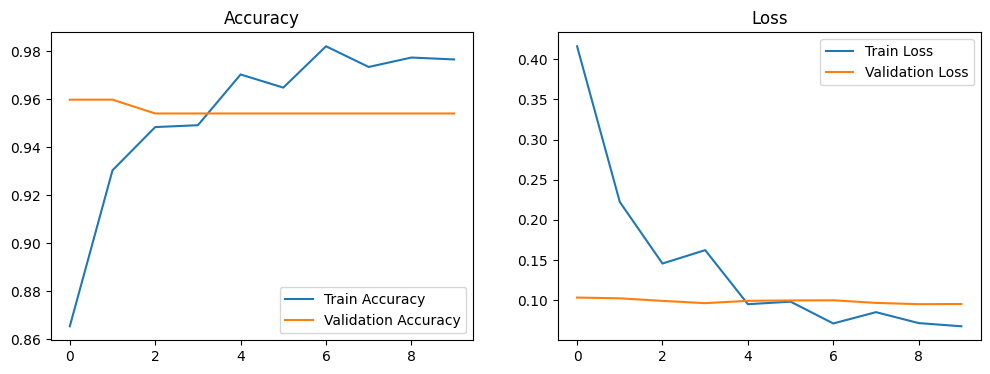

In [5]:
# Plot Akurasi dan Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted Class: penghapus


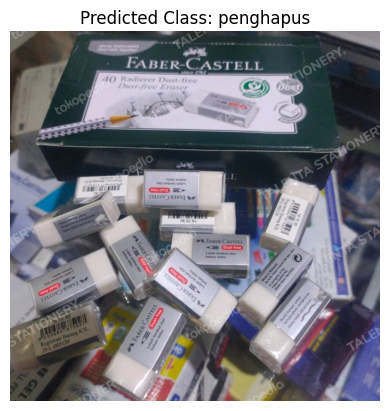

In [20]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Uji dengan gambar baru
img_path = "dataset/testing/test (20).jpg"
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0  # Normalisasi
img_array = np.expand_dims(img_array, axis=0)

# Prediksi
predictions = model.predict(img_array)
class_names = list(train_data.class_indices.keys())  # Nama kelas
predicted_class = class_names[np.argmax(predictions)]
print(f"Predicted Class: {predicted_class}")

plt.imshow(image.load_img(img_path))  # Tampilkan gambar asli
plt.axis('off')  # Hilangkan axis
plt.title(f"Predicted Class: {predicted_class}")  # Tampilkan prediksi di judul
plt.show()